# Learning phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [2]:
games_details = pd.read_csv('../dataset/complete_dataset.csv', low_memory=False)
rows_to_drop = games_details[games_details.isin([-1]).any(axis=1)].index
games_details.drop(rows_to_drop, inplace=True)
games_details = games_details.reset_index(drop=True)
games_details.drop(columns=['GAME_ID', 'DATE'], inplace=True)
games_details.head()

,TEAM_ID,PLAYER_ID,FG3M,DATE_DIFF,OPPOSING_TEAM,WINRATE,AVERAGE_TRIPLES,LOCATION,SEASON
0,1.610613e+09,2594.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
1,1.610613e+09,2223.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
2,1.610613e+09,2584.0,0.0,5.0,1610612748,0.333333,0.0,Home,2003.0
3,1.610613e+09,1890.0,1.0,4.0,1610612759,0.666667,0.0,Away,2003.0
4,1.610613e+09,2207.0,0.0,4.0,1610612759,0.666667,1.0,Away,2003.0


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# label encoder e non one-hot encoding per evitare di aumentare di molto
# dimensionalità del dataset e perché le date e simili hanno effettivamente un ordine

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
games_details = games_details.sample(frac=0.1)

categorical_columns = games_details.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
games_details[list(categorical_columns)] = games_details[list(categorical_columns)].apply(label_encoder.fit_transform)

games_details = games_details.dropna()
games_details = games_details.reset_index(drop=True)

X = games_details.loc[:, games_details.columns != 'FG3M']
y = games_details['FG3M']

reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])

In [8]:
num_folds = 3
n_jobs = -1
n_estimators = 500

num_features = X.shape[1]
p = int(np.ceil(num_features / 3))
rf_param_grid = {
    'max_features': ['sqrt', 'log2', p]
    
}

rf_regressor = RandomForestRegressor(n_estimators = n_estimators, n_jobs=n_jobs)
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X) # questo non sarebbe legittimo

grid_search = GridSearchCV(rf_regressor, rf_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

rf_best_params = grid_search.best_params_
print(rf_best_params)

{'max_features': 3}


In [9]:
rf_kfolds = KFold(n_splits=num_folds, shuffle=True)
gini_importances = pd.DataFrame(columns=X.columns)

for fold, (train_idx, test_idx) in enumerate(rf_kfolds.split(X)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    rf_regressor = RandomForestRegressor(n_estimators = n_estimators, max_features = rf_best_params['max_features'], n_jobs=n_jobs)
    
    rf_regressor.fit(X_train, y_train)
    
    y_pred = rf_regressor.predict(X_test)
    
    current_rf_mae = mean_absolute_error(y_test, y_pred)
    current_rf_mse = mean_squared_error(y_test, y_pred)
    current_rf_rmse = np.sqrt(current_rf_mse)
    
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_mse, current_rf_rmse]

    importances = rf_regressor.feature_importances_
    gini_importances.loc[fold] = importances

In [10]:
dummy_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in dummy_kfolds.split(X):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X_train, y_train)
    
    y_dummy_pred = dummy_regressor.predict(X_test)

    current_dummy_mae = mean_absolute_error(y_test, y_dummy_pred)
    current_dummy_mse = mean_squared_error(y_test, y_dummy_pred)
    current_dummy_rmse = np.sqrt(current_dummy_mse)

    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_mse, current_dummy_rmse]

In [11]:
knn_param_grid = {
    'n_neighbors': [1, 5, 50, 150],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, knn_param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

knn_best_params = grid_search.best_params_
print(knn_best_params)

{'n_neighbors': 10, 'p': 1}


In [12]:
knn_kfolds = KFold(n_splits=num_folds, shuffle=True)

for train_idx, test_idx in knn_kfolds.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors = knn_best_params['n_neighbors'], p = knn_best_params['p'])
    knn_regressor.fit(X_train, y_train)
    
    y_pred = knn_regressor.predict(X_test)
    
    current_knn_mae = mean_absolute_error(y_test, y_pred)
    current_knn_mse = mean_squared_error(y_test, y_pred)
    current_knn_rmse = np.sqrt(current_knn_mse)
    
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_mse, current_knn_rmse]

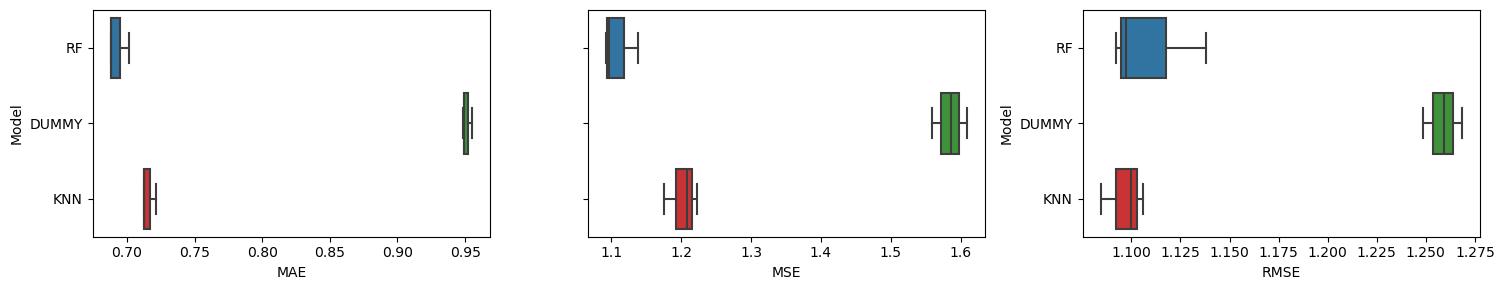

In [25]:
fig, axs = plt.subplots(1, 3, figsize= (15, 3))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MSE", y="Model", ax=axs[1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[2], palette=sns.color_palette('Paired')[1::2])
axs[1].set_yticklabels('')
axs[1].set_ylabel('')
plt.tight_layout()
plt.savefig('./images/errors.pdf')
plt.show()


# Adjust figsize if needed

In [26]:
from pandas.plotting import table
summary_errors = reg_metrics.groupby('Model').agg({'MAE': ['mean', 'std'],
                                      'MSE': ['mean', 'std'],
                                      'RMSE': ['mean', 'std']}).reset_index()

summary_errors.columns = ['Model', 'Mean MAE', 'Std MAE', 'Mean MSE', 'Std MSE', 'Mean RMSE', 'Std RMSE']

display(summary_df)

,Model,Mean MAE,Std MAE,Mean MSE,Std MSE,Mean RMSE,Std RMSE
0,DUMMY,0.950974,0.003526,1.584492,0.024967,1.258740,0.009921
1,KNN,0.715553,0.005143,1.202664,0.024328,1.096623,0.011113
2,RF,0.692641,0.007765,1.108937,0.025136,1.108937,0.025136


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    TEAM_ID  PLAYER_ID  DATE_DIFF  OPPOSING_TEAM   WINRATE  AVERAGE_TRIPLES  \
0  0.086756   0.124664   0.050840       0.122317  0.047727         0.460681   
1  0.085683   0.121410   0.052904       0.123009  0.047856         0.458970   
2  0.085573   0.120571   0.052181       0.120470  0.047490         0.465376   

   LOCATION    SEASON  
0  0.024132  0.082883  
1  0.024676  0.085491  
2  0.024904  0.083436  


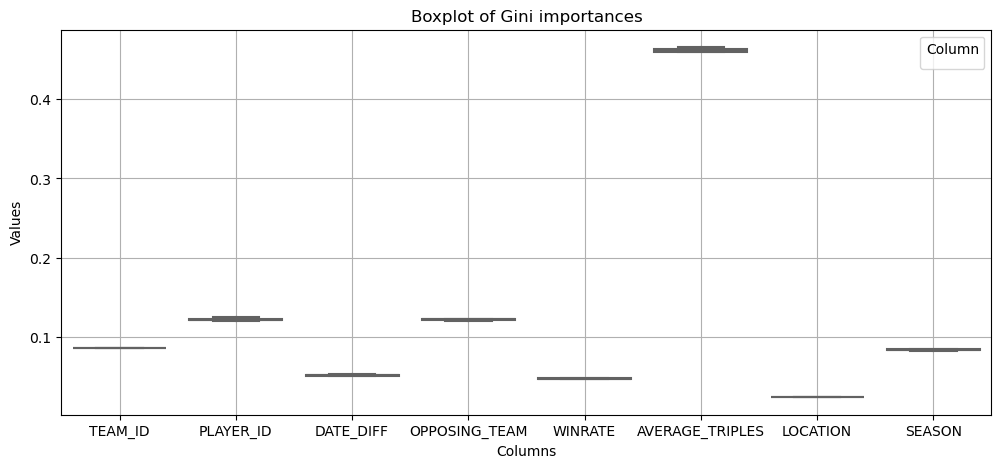

In [28]:
print(gini_importances)
melted_gini = gini_importances.melt(var_name='Column')

# Create boxplot with seaborn
plt.figure(figsize=(12, 5))
sns.boxplot(x='Column', y='value', data=melted_gini, palette='Set3')
#sns.boxplot(x='Column', y='value', data=melted_gini, hue='Column', palette='Set3')

plt.title('Boxplot of Gini importances')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.legend(title='Column')
plt.grid(True)
plt.show()

In [34]:
summary_gini = gini_importances.agg(['mean', 'std']).transpose().reset_index()
summary_gini.columns = ['Column', 'Average', 'Standard Deviation']
print(summary_gini)

            Column   Average  Standard Deviation
0          TEAM_ID  0.086004            0.000653
1        PLAYER_ID  0.122215            0.002162
2        DATE_DIFF  0.051975            0.001047
3    OPPOSING_TEAM  0.121932            0.001313
4          WINRATE  0.047691            0.000186
5  AVERAGE_TRIPLES  0.461676            0.003317
6         LOCATION  0.024571            0.000397
7           SEASON  0.083936            0.001374
